# Decision Tree Classification (CART)
> A tutorial on how to set-up a Plex server on Raspberry Pi

- toc: true 
- badges: true
- comments: true
- author: Kai Lewis
- categories: [jupyter, CART, classification, decisiontree]

# About

Decision trees are one of the best known *supervised* learning method used for both **classification** and **regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A decision tree can be seen a piecewise constant approximation. 

The CART algorithm provides the foundation for important methods like bagged decision trees, random forest and boosted decision trees. The output of a CART is a decision tree where each fork is a split in a predictor variable and each end node contains a prediction for the response variable. Essentially, it sequentially asks a series of if-else questions about individual features in a dataset in order to split it for classification. 

## Advantages of CARTs
- Decision tree model can be used for both classification and regression problems
- Outputs of decision trees are easily understood
- Data pre-processing step is easier as CARTs don't require normalisation of data (they may each have different scales)
- Not largely impaced by outliers or missing values
- Can handle both numerical and categorical variables
- Non-parametric method, therefore, makes no assumptions about the underlying distributions of the data

## Disadvantages of CARTs
- Overfitting is common in decision trees, as the algorithm continually makes new hypotheses to reduce training set error but incidentally increase test set error. This may be accounted for by setting constraints on model parameters.
- Small changes in data tends to cause large differences in tree structure
- Can take longer to train the model than other algorithms

## Iris dataset
The famous Iris dataset, first used by Sir R.A. Fisher. The dataset is taken from Fisher's paper in 1936.

We will be using this classic dataset to build a decision tree classifier to predict the class of the iris plant based on its attributes.

# Import packages
The packages we need for the downstream analysis

In [2]:
from matplotlib import pyplot as plt
import plotly_express as px
import seaborn as sns

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np 

# Exploratory data analysis (EDA) 

This is where we investigate the datasets characteristics and observe the data directly to identify underlying issues with missing data and outliers. Given this is a curated example, this won't be an issue. However, this is always an important step when conducting any statistical analysis.

In [3]:
# Prepare the data data
iris = datasets.load_iris()

# Description of the dataset
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
# Create pandas dataframe from SciKit-learns bunch object

iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)

iris_df['target'] = iris.target

# Create the dictionary
species_dictionary = {0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}

# Assign new column values
iris_df['Species'] = iris_df['target'].map(species_dictionary).astype(str)

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,Species
0,5.1,3.5,1.4,0.2,0,Iris-Setosa
1,4.9,3.0,1.4,0.2,0,Iris-Setosa
2,4.7,3.2,1.3,0.2,0,Iris-Setosa
3,4.6,3.1,1.5,0.2,0,Iris-Setosa
4,5.0,3.6,1.4,0.2,0,Iris-Setosa


In [40]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [6]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
 5   Species            150 non-null    object 
dtypes: float64(4), int32(1), object(1)
memory usage: 6.6+ KB


<Figure size 576x576 with 0 Axes>

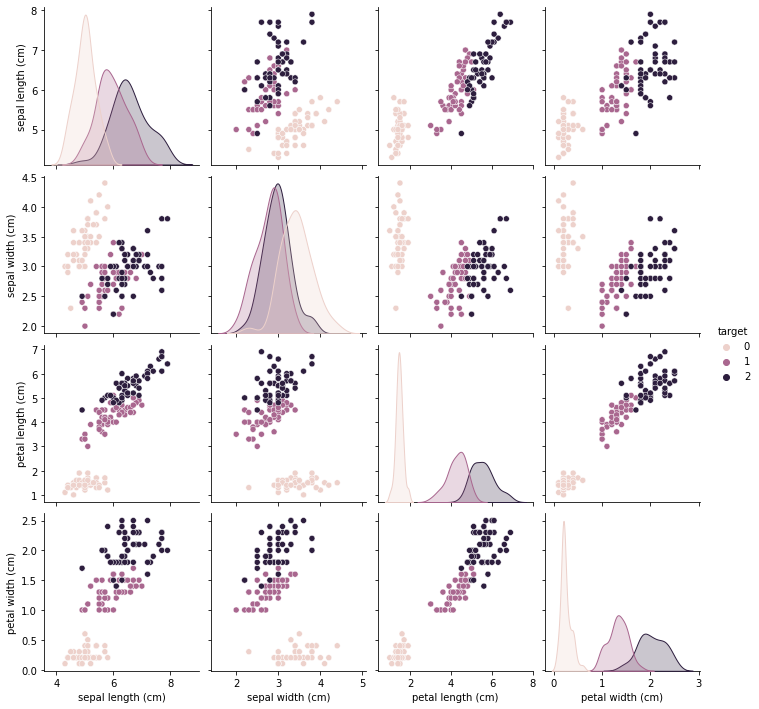

In [5]:
plt.figure(figsize=(8, 8))
ax = sns.pairplot(iris_df, hue='target')
plt.show()

## EDA outcomes
- There aren't any missing values, all columns have 150 values. Therefore it's not necessary to account for missing values.
- All data types are numerical (float64/int32). This is important as Scikit-Learn models do not accept categorical data. These must be converted into dummy variables represented as 0s and 1s.
- Data appears to cluster by species meaning that classification will probably work well to define each category.

# Classification and regression tree (CART)

## Two most popular backbones for decision tree *decisions* are the Gini index and Information entropy
As mentioned above, a tree is composed of nodes. These nodes are chosen by looking for the **optimal split** of the features. The split decision is made by measuring the *quality* of the split. Both the Gini index and Information entropy are measures of this quality of the split.

Before this, we must set-up our training and test datasets using the train_test_split module from SciKit-learn's model_selection library. The purpose of this is to ensure the model is not trained on all available data, allowing us to test how it performs on unseen data. If we used all the data to train the model, we may end up overfitting the model causing it to perform badly on unseen data.

In [6]:
X = iris.data
y = iris.target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=1)

## Gini index
It is calculated using the following formula:

*GiniIndex* $ = 1 - \sum \limits _{j} p^2_{j} $

Where $p_{j}$ is the probability of class j.

The gini impurity measures the frequency at which any element of the dataset will be mislabelled when it is randomly sampled. The minimum value of the Gini Index is 0. This happens when the node is pure, this means that all the contained elements in the node are of one unique class. Therefore, this node will not be split again. Thus, the optimum split is chosen by the features with less Gini Index. Moreover, it gets the maximum value when the probability of the two classes are the same.


In [7]:
# Instantiate the decision tree
dt_gini = DecisionTreeClassifier(max_depth= 3, criterion= 'gini', random_state= 1234)

# Fit the decision tree to the data
dt_gini.fit(X_train, y_train)

# Predict test set labels
y_pred = dt_gini.predict(X_test)

# Calculate accuracy score
acc_dt_gini = accuracy_score(y_test, y_pred)

print(f"Accuracy score of decision tree: {acc_dt_gini}")

Accuracy score of decision tree: 0.9666666666666667


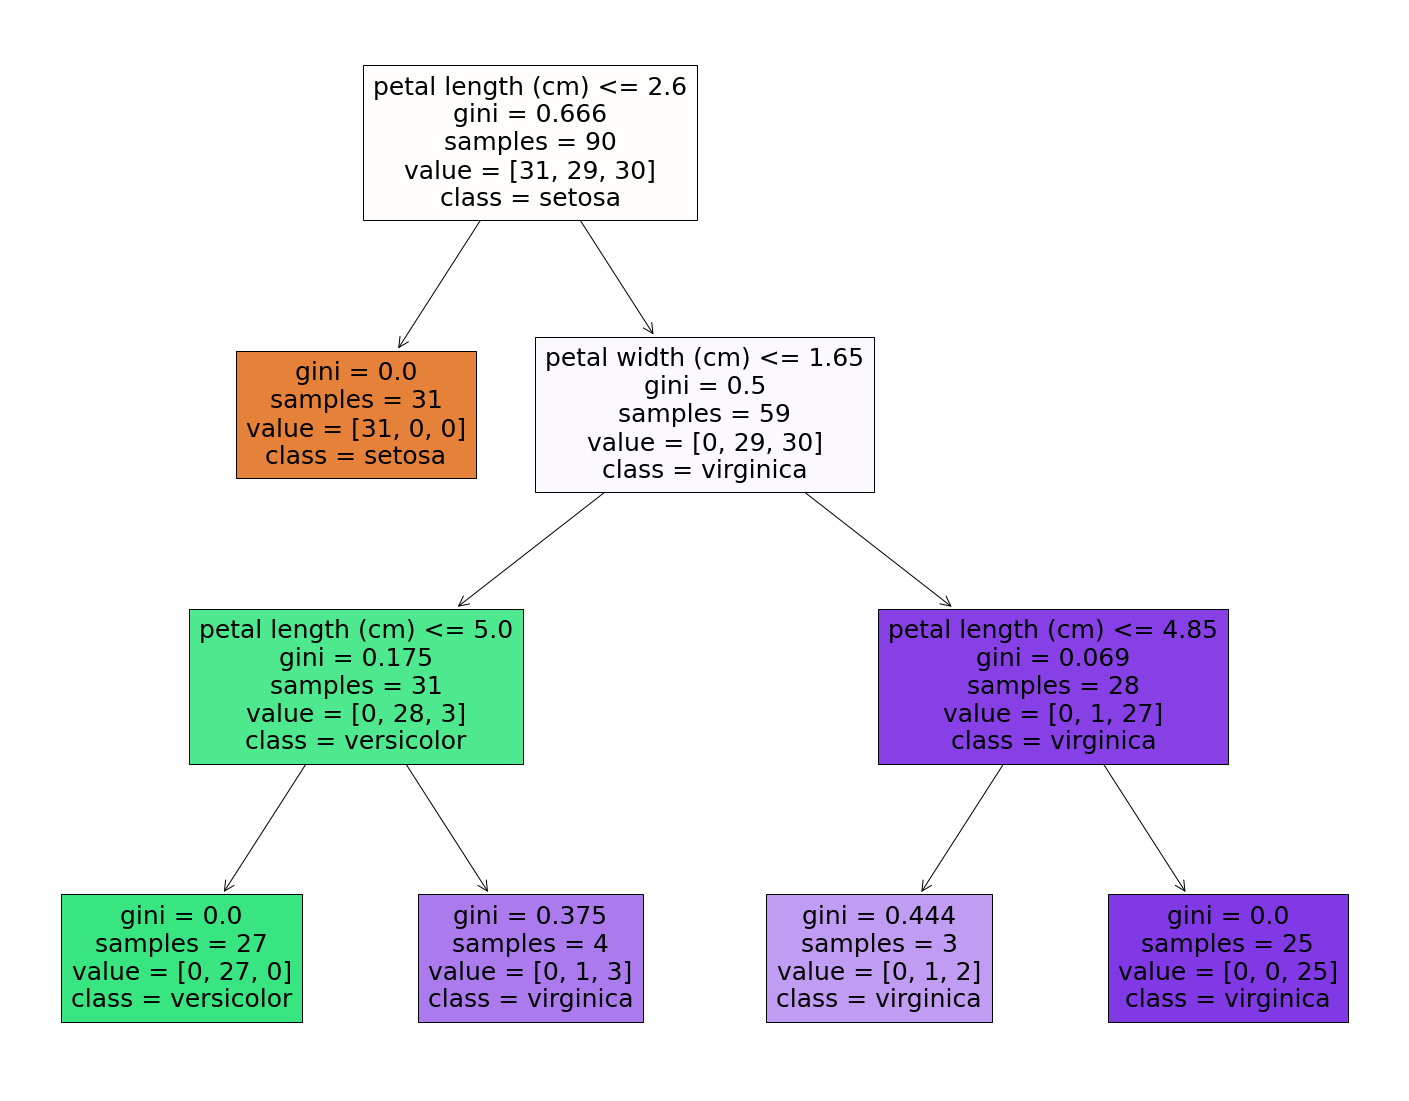

In [8]:
fig = plt.figure(figsize=(25,20))
tree_plot = tree.plot_tree(dt_gini, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

## Information entropy
It is calculated using the following formula:

*Entropy* $ = \sum \limits _{j} p_{j}.log_{2}.p_{j} $

Where $p_{j}$ is the probability of class j.

Entropy is a measure of information that indicates the disorder of the features with the target. Similar to the Gini Index, the optimum split is chosen by the feature with less entropy. It gets its maximum value when the probability of the two classes is the same and a node is pure when the entropy has its minimum value, which is 0.

In [11]:
# Instantiate the decision tree
dt_entropy = DecisionTreeClassifier(max_depth= 3, criterion= 'entropy', random_state= 1234)

# Fit the decision tree to the data
dt_entropy.fit(X_train, y_train)

# Predict test set labels
y_pred = dt_entropy.predict(X_test)

# Set new var with accuracy
acc_dt_entropy = accuracy_score(y_test, y_pred)

print(f"Accuracy score of decision tree: {acc_dt_entropy}")

Accuracy score of decision tree: 0.9666666666666667


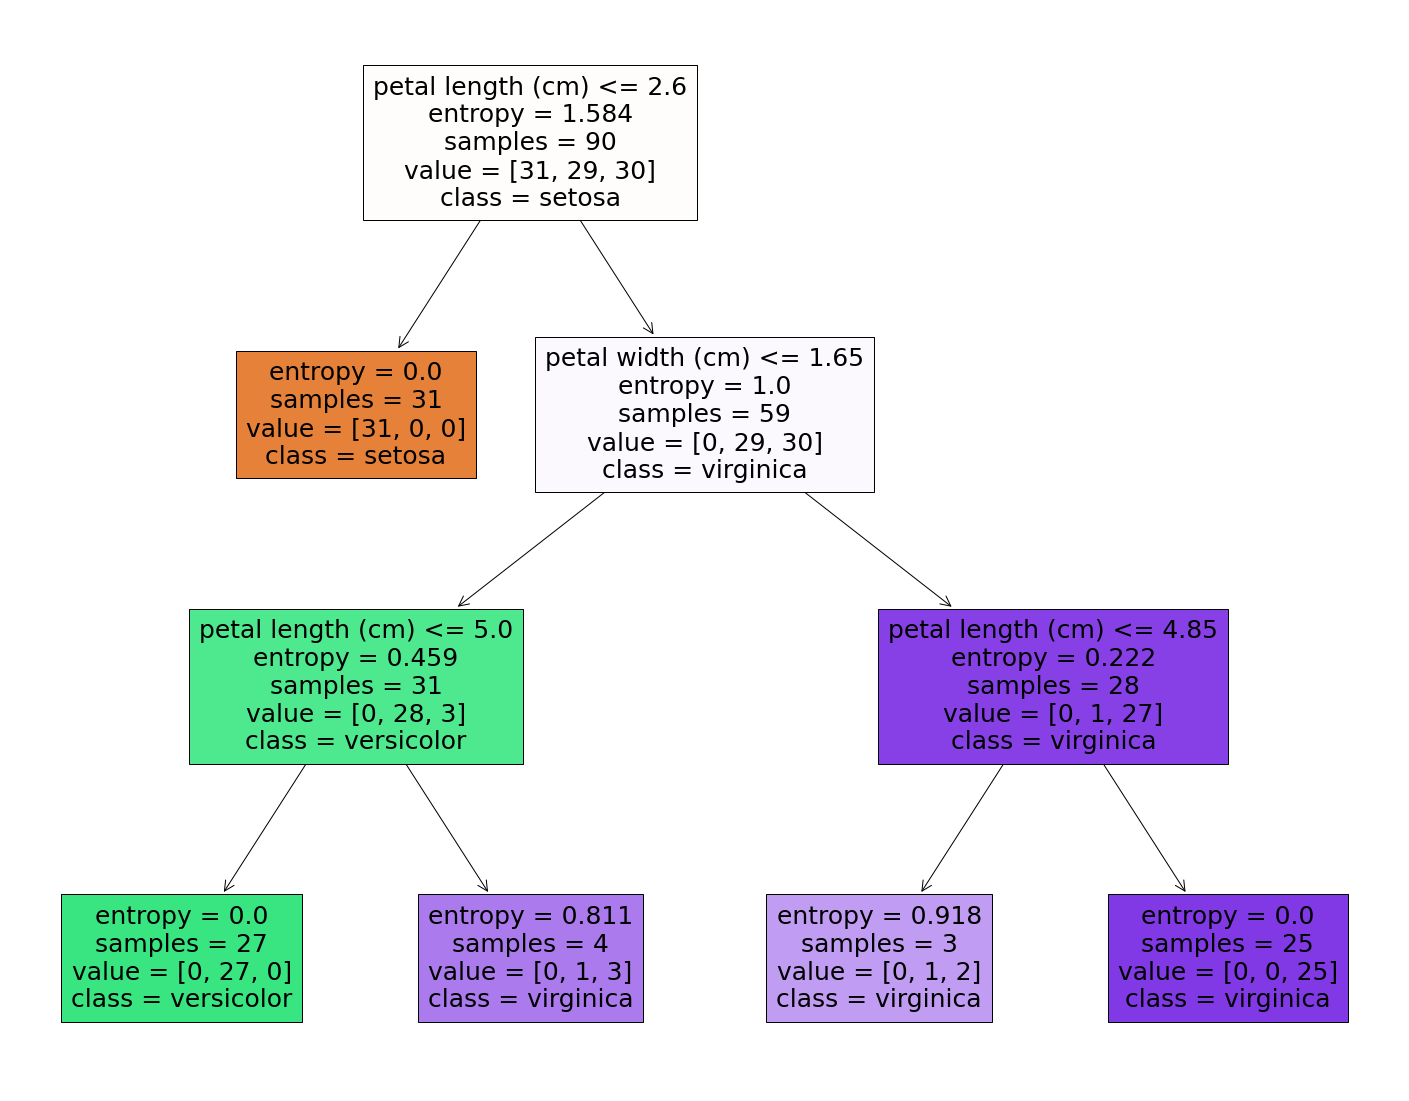

In [12]:
fig = plt.figure(figsize=(25,20))
tree_plot = tree.plot_tree(dt_entropy, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)